## LangGraph 기반 Multiquery Retriever RAG 시스템

## 🤔 왜 Multi-Query Retriever가 필요한가?

### 기존 RAG 시스템의 한계점
- **단일 쿼리의 제약**: 사용자의 질문이 모호하거나 불완전할 때 관련 문서를 놓칠 수 있음
- **의미적 표현의 다양성**: 같은 의미라도 다양한 표현 방식으로 인해 검색 성능이 제한됨
- **검색 범위의 한계**: 하나의 쿼리로는 복합적인 정보 요구사항을 충족하기 어려움

### Multi-Query Retriever의 장점
✅ **검색 범위 확장**: 여러 관점에서 동일한 정보를 검색하여 누락 방지  
✅ **의미적 다양성**: 다양한 표현으로 쿼리를 생성하여 검색 정확도 향상  
✅ **컨텍스트 풍부화**: 다각도의 검색 결과를 통합하여 더 완전한 답변 생성  
✅ **견고성 증대**: 단일 쿼리 실패 시에도 다른 쿼리들이 보완 역할 수행

## 📋 시스템 개요
이 시스템은 다음과 같은 컴포넌트들로 구성됩니다:

1. **PDF 문서 로딩** (PyPDF)
2. **문서 청킹 및 임베딩** (LangChain + Ollama)
3. **벡터 저장소** (Qdrant)
4. **멀티쿼리 생성** (Gemma 3) - 핵심 개선 포인트
5. **워크플로우 관리** (LangGraph)
6. **검색 및 생성** (LangGraph)

## 1. 환경 설정

기본적인 라이브러리 임포트와 환경 변수 로딩을 수행합니다. 경고 메시지를 비활성화하여 출력을 깔끔하게 유지합니다.


In [1]:
# 셀 1: 기본 환경 설정
import os
import warnings
from dotenv import load_dotenv
load_dotenv()
warnings.filterwarnings('ignore')

## 2. PDF 문서 로딩

데이터 폴더에서 PDF 파일들을 로딩하고 각 문서에 메타데이터를 추가합니다. PyPDFLoader를 사용하여 PDF 파일을 페이지 단위로 분할하여 처리합니다.


In [2]:
# 셀 2: PDF 문서 로딩을 위한 라이브러리
from langchain_community.document_loaders import PyPDFLoader
from typing import List
import glob

def load_pdf_documents(data_folder: str) -> List:
    """
    PDF 문서들을 로딩하는 함수
    
    Args:
        data_folder: PDF 파일들이 있는 폴더 경로
    
    Returns:
        로딩된 문서들의 리스트
    """
    documents = []
    
    # PDF 파일 목록 가져오기
    pdf_files = glob.glob(f"{data_folder}/*.pdf")
    
    for pdf_path in pdf_files:
        print(f"📄 로딩 중: {os.path.basename(pdf_path)}")
        
        # PyPDF를 사용하여 PDF 로딩
        loader = PyPDFLoader(pdf_path)
        file_documents = loader.load()
        
        # 문서에 출처 정보 추가
        for doc in file_documents:
            doc.metadata['source_file'] = os.path.basename(pdf_path)
            
        documents.extend(file_documents)
    
    print(f"✅ 총 {len(documents)}개의 문서 페이지가 로딩되었습니다.")
    return documents

# 사용 예시
documents = load_pdf_documents("./data/agentic_retrieval/medical")

📄 로딩 중: 질병관리청_2025년_성과관리_시행계획.pdf
📄 로딩 중: 질병관리청_2025년_주요업무_추진계획.pdf
📄 로딩 중: 질병관리청_전세계_감염병_발생_동향_2025년.pdf
✅ 총 301개의 문서 페이지가 로딩되었습니다.


## 3. 문서 길이 분포 분석 및 시각화

로딩된 PDF 문서들의 페이지별 내용 길이를 분석하고 히스토그램으로 시각화합니다. 이를 통해 문서의 특성을 파악하고 청킹 전략을 수립할 수 있습니다.


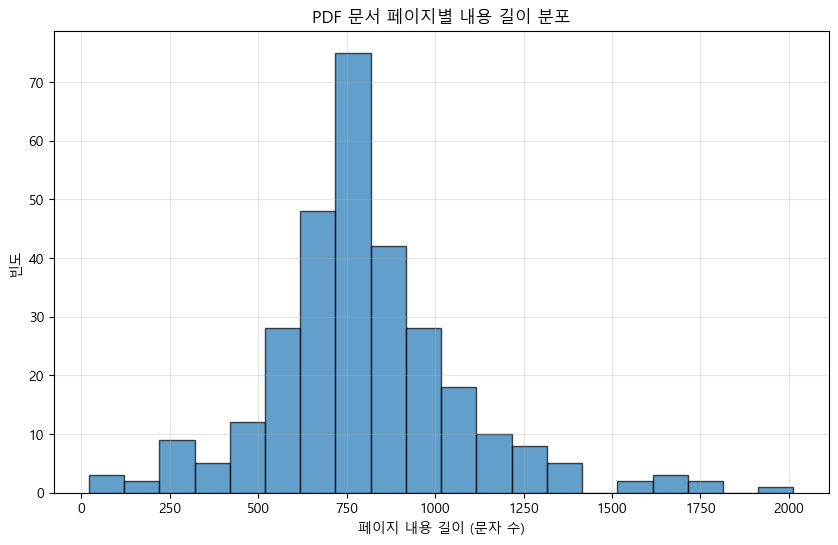

평균 길이: 801 문자
최소 길이: 21 문자
최대 길이: 2013 문자
총 페이지 수: 301개


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
try:
    # 시스템에 설치된 한글 폰트 찾기
    font_list = [f.name for f in fm.fontManager.ttflist]
    korean_fonts = ['Malgun Gothic', 'NanumGothic', 'AppleGothic', 'Noto Sans CJK KR']
    
    for font in korean_fonts:
        if font in font_list:
            plt.rcParams['font.family'] = font
            break
except:
    pass

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 각 문서 페이지의 길이 계산
page_lengths = [len(i.page_content) for i in documents]

# 히스토그램으로 문서 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(page_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('페이지 내용 길이 (문자 수)')
plt.ylabel('빈도')
plt.title('PDF 문서 페이지별 내용 길이 분포')
plt.grid(True, alpha=0.3)
plt.show()

# 기본 통계 정보 출력
print(f"평균 길이: {sum(page_lengths)/len(page_lengths):.0f} 문자")
print(f"최소 길이: {min(page_lengths)} 문자")
print(f"최대 길이: {max(page_lengths)} 문자")
print(f"총 페이지 수: {len(page_lengths)}개")

## 4. 임베딩 모델 및 벡터 데이터베이스 설정

Ollama의 BGE-M3 임베딩 모델을 초기화하고 Qdrant 벡터 데이터베이스에 문서들을 저장합니다. 저장된 문서에 대해 간단한 검색 테스트를 수행하여 시스템이 정상 작동하는지 확인합니다.


In [4]:
# 셀 4: 임베딩 및 벡터 데이터베이스 설정
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import QdrantVectorStore, RetrievalMode
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

# Ollama 임베딩 모델 초기화
embeddings = OllamaEmbeddings(
    model="bge-m3"
)

client = QdrantClient("localhost", port=6333)

try:
    client.create_collection(
        collection_name="multi_query",
        vectors_config={"dense": VectorParams(size=1024, distance=Distance.COSINE)}
    )
except:
    pass
# LangChain QdrantVectorStore 초기화
vector_store = QdrantVectorStore(
    client=client,
    collection_name="multi_query",
    embedding=embeddings,
    retrieval_mode=RetrievalMode.DENSE,
    vector_name="dense",
)

# 문서를 벡터 저장소에 추가
print("🔄 문서 임베딩 및 저장 중...")
vector_store.add_documents(documents)
print(f"✅ {len(documents)}개 문서가 벡터 저장소에 추가되었습니다.")



🔄 문서 임베딩 및 저장 중...
✅ 301개 문서가 벡터 저장소에 추가되었습니다.

🔍 테스트 검색 결과 (쿼리: '자율주행 시스템'):
1. - 79 -
자적 운영체계 MB.OS를 개발하고 있으며, 2025년 공개할 신규 플랫폼 MMA(Mercedes Modular Architecture)와  MB.OS 1.0를 모든 ...
2. - 8 -
자율주행 시스템은 인지·판단·제어 프로세스에 따라 센서 융합, AI 알고리즘, 실시간 데이터 처리 기술을 활용해 주변 환경을 인식하고 반응하며, 잠재적인 시나리오를 예측...
3. - 86 -
자율비행 기술은 자율주행 기술과 유사하게 GPS, 카메라, 라이다 등 다양한 센서 및 통신 연결을 통해 실시간 정보를 수집하여 위치 및 주변 환경을 인식한 이후에 최적...


In [5]:
# 검색 테스트
test_query = "감염병 관리 시스템"
search_results = vector_store.similarity_search(test_query, k=3)
print(f"\n🔍 테스트 검색 결과 (쿼리: '{test_query}'):")
for i, doc in enumerate(search_results, 1):
    print(f"{i}. {doc.page_content[:100]}...")


🔍 테스트 검색 결과 (쿼리: '감염병 관리 시스템'):
1. - 99 -
□ 기대효과 ㅇ 감염병 관리체계 강화로 인한 주요 감염병 예방·관리 강화-홍역‧폴리오 등 WHO퇴치 및 박멸 인증국 지위 유지-바이러스 간염 관리 기본계획 추진을 통한...
2. - 61 -
 근거 기반 정책 수립을 위한 감염병 데이터 활용 체계 강화(Ⅰ-2-②)국정기조 등 연계ㅇ 국가 감염병 거버넌스 및 방역 대응 체계 선진화(국정 2-2)ㅇ 다층적 감...
3. - 187 -
 의료관련감염 예방관리 체계 강화(Ⅱ-3-④)국정기조 등 연계ㅇ 국가 감염병 거버넌스 및 방역 대응 체계 선진화(국정 2-2)ㅇ 의료관련 감염, 항생제 내성으로부터...


## 5. LLM 모델 초기화

ChatOllama를 사용하여 Gemma3 4B 모델을 초기화합니다. 이 모델은 멀티쿼리 생성과 최종 답변 생성에 사용됩니다.


In [6]:
from langchain_ollama import ChatOllama

gemma=ChatOllama(model="gemma3:4b")

## 6. 멀티쿼리 생성기 구현

원본 질문을 다양한 관점에서 재구성하여 여러 개의 검색 쿼리를 생성하는 시스템을 구현합니다. 

LineListOutputParser를 사용하여 LLM 출력을 파싱하고, 프롬프트 템플릿을 통해 일관된 쿼리 생성을 보장합니다.


In [7]:
# 셀 6: 멀티쿼리 생성을 위한 프롬프트와 함수
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from typing import List

# Output parser will split the LLM result into a list of queries
class LineListOutputParser(BaseOutputParser[List[str]]):
    """Output parser for a list of lines."""

    def parse(self, text: str) -> List[str]:
        lines = text.strip().split("\n")
        return list(filter(None, lines))  # Remove empty lines

def create_multiquery_generator(llm, num_queries=3):
    """멀티쿼리 생성기 생성"""
    
    # Output parser 초기화
    output_parser = LineListOutputParser()
    
    # 멀티쿼리 생성 프롬프트
    QUERY_PROMPT = PromptTemplate(
        input_variables=["question", "num_queries"],
        template="""당신은 AI 어시스턴트입니다. 사용자의 질문을 다양한 관점에서 재구성하여 
                    더 포괄적인 검색이 가능하도록 도와주세요. 거리 기반 유사도 검색의 한계를 극복하기 위해 
                    원본 질문에 대한 다양한 관점의 질문들을 {num_queries}개 생성해주세요.

                    각 질문은 줄바꿈으로 구분하여 제공해주세요.
                    원본 질문: {question}
                    {num_queries}개의 질문:
                    (print from here)
                    """
    )
    
    # 멀티쿼리 생성 체인 생성 (이것이 Runnable입니다)
    multiquery_chain = QUERY_PROMPT | llm | output_parser
    
    print(f"🔍 멀티쿼리 생성기 설정 완료 (질문 수: {num_queries}개)")
    return multiquery_chain


In [8]:
# 멀티쿼리 생성기 생성
multiquery_generator = create_multiquery_generator(gemma, 5)
multiquery_generator.invoke({"question": "감염병 관리 시스템", "num_queries": 5})

🔍 멀티쿼리 생성기 설정 완료 (질문 수: 5개)


['감염병 확산 방지를 위한 시스템 구축 방안은 무엇인가?',
 '감염병 발생 시 신속한 대응을 위한 시스템의 효과적인 운영 모델은 무엇인가?',
 '감염병 관리 시스템의 기술적 요소(데이터 분석, 예측 모델 등)는 어떻게 구성되어야 하는가?',
 '감염병 관리 시스템 구축 시 고려해야 할 사회적, 윤리적 문제점은 무엇인가?',
 '감염병 관리 시스템의 효율성을 평가하고 개선하기 위한 지표는 무엇인가?']

## 7. 멀티쿼리 생성기 테스트

다양한 주제의 질문들로 멀티쿼리 생성기를 테스트합니다. 자율주행, AI 윤리, 블록체인 등 10가지 주제에 대해 각각 5개의 다양한 관점의 쿼리를 생성하여 시스템의 성능을 검증합니다.


In [9]:
# 다양한 쿼리로 멀티쿼리 생성기 테스트
test_queries = [
    "자율주행 시스템",
    "인공지능의 윤리적 문제",
    "블록체인 기술의 활용",
    "기후변화 대응 방안",
    "메타버스의 미래",
    "양자컴퓨팅의 원리",
    "바이오테크놀로지 발전",
    "재생에너지 기술",
    "로봇공학의 응용",
    "사이버보안 위협"
]

# 각 쿼리에 대해 멀티쿼리 생성 테스트
test_results = []
for i, query in enumerate(test_queries, 1):
    print(f"\n=== 테스트 {i}: {query} ===")
    try:
        result = multiquery_generator.invoke({"question": query, "num_queries": 5})
        test_results.append({
            "original_query": query,
            "generated_queries": result,
            "count": len(result),
            "success": True
        })
        print(f"생성된 쿼리 수: {len(result)}")
        for j, generated_query in enumerate(result, 1):
            print(f"{j}. {generated_query}")
    except Exception as e:
        test_results.append({
            "original_query": query,
            "generated_queries": [],
            "count": 0,
            "success": False,
            "error": str(e)
        })
        print(f"오류 발생: {e}")

# 테스트 결과 요약
print("\n" + "="*50)
print("테스트 결과 요약")
print("="*50)
successful_tests = sum(1 for result in test_results if result["success"])
print(f"성공한 테스트: {successful_tests}/{len(test_queries)}")
print(f"평균 생성 쿼리 수: {sum(result['count'] for result in test_results if result['success']) / successful_tests if successful_tests > 0 else 0:.1f}")

# 실패한 테스트가 있다면 출력
failed_tests = [result for result in test_results if not result["success"]]
if failed_tests:
    print(f"\n실패한 테스트 ({len(failed_tests)}개):")
    for result in failed_tests:
        print(f"- {result['original_query']}: {result.get('error', 'Unknown error')}")


=== 테스트 1: 자율주행 시스템 ===
생성된 쿼리 수: 5
1. 자율주행 시스템의 기술적 작동 원리는 무엇인가?
2. 자율주행 시스템이 도로 안전에 미치는 영향은 무엇이며, 어떤 위험 요소가 존재하는가?
3. 자율주행 시스템의 경제적 효과와 사회적 파급 효과는 무엇인가?
4. 자율주행 시스템의 윤리적 문제점과 해결 방안은 무엇인가?
5. 자율주행 시스템의 현재 기술 수준과 미래 발전 방향은 어떻게 될 것인가?

=== 테스트 2: 인공지능의 윤리적 문제 ===
생성된 쿼리 수: 5
1. 인공지능 시스템의 의사 결정 과정에서 발생할 수 있는 윤리적 책임 문제는 무엇인가?
2. 인공지능 기술 발전이 인간의 일자리 및 사회 구조에 미치는 윤리적 영향은 무엇이며, 이에 대한 해결책은 무엇인가?
3. 인공지능이 학습 데이터에 내재된 편향성을 어떻게 해결하고, 그 과정에서 발생할 수 있는 차별 문제를 방지할 수 있는가?
4. 인공지능의 자율성 증대에 따라 인간의 통제 및 감독의 필요성은 어떻게 변화하며, 그 윤리적 기준은 무엇인가?
5. 인공지능이 인간의 존엄성, 프라이버시, 자기 결정권 등 기본적인 인권에 미치는 영향에 대한 윤리적 논의는 어떻게 이루어져야 하는가?

=== 테스트 3: 블록체인 기술의 활용 ===
생성된 쿼리 수: 5
1. 블록체인 기술의 활용 사례는 무엇이며, 각 사례별로 어떤 산업 분야에 적용되고 있는가?
2. 블록체인 기술이 기존 시스템의 문제점을 어떻게 해결하며, 구체적으로 어떤 효율성 향상을 가져오고 있는가?
3. 블록체인 기술의 보안 및 투명성 특징이 특정 산업 또는 서비스에 미치는 영향은 무엇이며, 그 효과를 측정하는 방법은 무엇인가?
4. 블록체인 기술의 확장성 문제와 이를 해결하기 위한 다양한 기술적 접근 방식은 무엇이며, 각 방식의 장단점은 무엇인가?
5. 블록체인 기술의 상용화 및 대중화에 영향을 미치는 주요 요인(규제, 기술, 시장 수용도 등)은 무엇이며, 이러한 요인들이 블록체인 기술의 미래를 어떻게 예측하는가?

===

## 8. LangGraph 상태 정의

RAG 워크플로우에서 사용할 상태 구조를 TypedDict로 정의합니다. 원본 질문, 생성된 쿼리들, 검색된 문서들, 최종 답변, 단계별 정보를 포함합니다.


In [10]:
# 셀 7: LangGraph 상태 정의
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END

class RAGState(TypedDict):
    """RAG 워크플로우 상태 정의"""
    original_question: str
    generated_queries: List[str]
    retrieved_documents: List[Dict[str, Any]]
    final_answer: str
    step_info: Dict[str, Any]

print("📊 LangGraph 상태 정의 완료")

📊 LangGraph 상태 정의 완료


## 9. 멀티쿼리 생성 노드 구현

LangGraph 워크플로우의 첫 번째 노드로, 원본 질문으로부터 여러 개의 검색 쿼리를 생성합니다. 원본 질문도 포함하여 총 6개의 쿼리를 생성하고 상태를 업데이트합니다.


In [11]:
# 셀 8: 멀티쿼리 생성 노드
def generate_multiple_queries(state: RAGState) -> RAGState:
    """원본 질문으로부터 여러 검색 쿼리 생성"""
    
    print(f"🔄 멀티쿼리 생성 중: {state['original_question']}")
    
    # 멀티쿼리 생성
    response = multiquery_generator.invoke({"question": state["original_question"], "num_queries": 5})
    
    # 원본 질문도 포함
    all_queries = [state["original_question"]] + response
    
    print(f"✅ {len(all_queries)}개 쿼리 생성 완료")
    for i, q in enumerate(all_queries):
        print(f"  {i+1}. {q}")
    
    return {
        **state,
        "generated_queries": all_queries,
        "step_info": {"queries_generated": len(all_queries)}
    }

## 10. 멀티쿼리 생성 노드 테스트

생성된 멀티쿼리 노드의 동작을 테스트합니다. 샘플 질문으로 파이썬의 리스트와 튜플의 차이점에 대한 질문을 사용하여 쿼리 생성 과정을 검증합니다.


In [12]:
# 멀티쿼리 생성 노드 테스트
print("\n" + "="*50)
print("멀티쿼리 생성 노드 테스트")
print("="*50)

# 테스트 상태 생성
test_state = RAGState(
    original_question="파이썬에서 리스트와 튜플의 차이점은 무엇인가요?",
    generated_queries=[],
    retrieved_documents=[],
    final_answer="",
    step_info={}
)

try:
    # 멀티쿼리 생성 노드 실행
    result_state = generate_multiple_queries(test_state)
    
    print(f"\n📋 테스트 결과:")
    print(f"원본 질문: {result_state['original_question']}")
    print(f"생성된 쿼리 수: {len(result_state['generated_queries'])}")
    print(f"단계 정보: {result_state['step_info']}")
    
except Exception as e:
    print(f"❌ 테스트 실패: {e}")


멀티쿼리 생성 노드 테스트
🔄 멀티쿼리 생성 중: 파이썬에서 리스트와 튜플의 차이점은 무엇인가요?
✅ 6개 쿼리 생성 완료
  1. 파이썬에서 리스트와 튜플의 차이점은 무엇인가요?
  2. 파이썬 리스트와 튜플의 주요 차이점은 무엇인가요?
  3. 파이썬 리스트와 튜플의 변경 가능성(mutability)에 대한 차이점을 설명해주세요.
  4. 파이썬에서 리스트와 튜플을 사용할 때 고려해야 할 성능상의 차이점은 무엇인가요?
  5. 파이썬 리스트와 튜플의 메모리 사용량에 미치는 영향은 어떻게 다른가요?
  6. 파이썬에서 리스트와 튜플을 사용하여 데이터 구조를 설계할 때 어떤 경우에 각각을 선택하는 것이 더 적합한가요?

📋 테스트 결과:
원본 질문: 파이썬에서 리스트와 튜플의 차이점은 무엇인가요?
생성된 쿼리 수: 6
단계 정보: {'queries_generated': 6}


## 11. 문서 검색 노드 구현

생성된 멀티쿼리들을 사용하여 벡터 데이터베이스에서 관련 문서를 검색하는 노드입니다.

 각 쿼리마다 상위 3개 문서를 검색하고 중복을 제거하여 최종 문서 집합을 구성합니다.


In [13]:
# 셀 9: 문서 검색 노드
def retrieve_documents(state: RAGState) -> RAGState:
    """생성된 쿼리들로 문서 검색"""
    
    print("🔍 문서 검색 중...")
    
    all_docs = []
    seen_content = set()  # 중복 제거용
    
    for i, query in enumerate(state["generated_queries"]):
        print(f"  쿼리 {i+1} 검색: {query[:50]}...")
        
        # 각 쿼리로 문서 검색 (상위 3개)
        docs = vector_store.similarity_search(query, k=3)
        
        for doc in docs:
            # 중복 문서 제거
            content_hash = hash(doc.page_content)
            if content_hash not in seen_content:
                seen_content.add(content_hash)
                all_docs.append({
                    "content": doc.page_content,
                    "metadata": doc.metadata,
                    "source_query": query
                })
    
    print(f"✅ 총 {len(all_docs)}개 고유 문서 검색 완료")
    
    return {
        **state,
        "retrieved_documents": all_docs,
        "step_info": {**state.get("step_info", {}), "documents_retrieved": len(all_docs)}
    }

## 12. 문서 검색 노드 테스트

문서 검색 노드의 동작을 테스트합니다.

 RAG 시스템 성능 향상과 관련된 3개의 테스트 쿼리를 사용하여 검색 기능이 올바르게 작동하는지 확인하고 검색된 문서들을 출력합니다.


In [14]:
# 문서 검색 노드 테스트
print("🧪 문서 검색 노드 테스트")
print("=" * 50)

try:
    # 테스트용 상태 (이전 단계에서 생성된 쿼리들 포함)
    test_state = {
        "original_question": "RAG 시스템의 성능을 향상시키는 방법은?",
        "generated_queries": [
            "RAG 시스템 성능 최적화 기법",
            "검색 증강 생성 모델 개선 방안",
            "RAG 정확도 향상 전략"
        ],
        "step_info": {"queries_generated": 3}
    }
    
    # 문서 검색 실행
    result_state = retrieve_documents(test_state)
    
    print(f"\n📋 테스트 결과:")
    print(f"원본 질문: {result_state['original_question']}")
    print(f"검색 쿼리 수: {len(result_state['generated_queries'])}")
    print(f"검색된 문서 수: {len(result_state['retrieved_documents'])}")
    print(f"단계 정보: {result_state['step_info']}")
    
    # 검색된 문서 샘플 출력
    print(f"\n📄 검색된 문서 샘플:")
    for i, doc in enumerate(result_state['retrieved_documents'][:2]):  # 상위 2개만 출력
        print(f"  문서 {i+1}:")
        print(f"    내용: {doc['content'][:100]}...")
        print(f"    소스 쿼리: {doc['source_query'][:50]}...")
        print(f"    메타데이터: {doc['metadata']}")
        print()
    
except Exception as e:
    print(f"❌ 테스트 실패: {e}")


🧪 문서 검색 노드 테스트
🔍 문서 검색 중...
  쿼리 1 검색: RAG 시스템 성능 최적화 기법...
  쿼리 2 검색: 검색 증강 생성 모델 개선 방안...
  쿼리 3 검색: RAG 정확도 향상 전략...
✅ 총 7개 고유 문서 검색 완료

📋 테스트 결과:
원본 질문: RAG 시스템의 성능을 향상시키는 방법은?
검색 쿼리 수: 3
검색된 문서 수: 7
단계 정보: {'queries_generated': 3, 'documents_retrieved': 7}

📄 검색된 문서 샘플:
  문서 1:
    내용: ...
    소스 쿼리: RAG 시스템 성능 최적화 기법...
    메타데이터: {'producer': 'ESTsoft ALPDF', 'creator': 'ESTsoft ALPDF', 'creationdate': '2025-04-13T23:40:30+09:00', 'author': 'user', 'moddate': '2025-04-13T23:40:38+09:00', 'title': '보험금 청구서', 'source': './data\\보험금 청구서.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1', 'source_file': '보험금 청구서.pdf', '_id': '50dcbaae-75ff-4caa-bd78-849a675af2b2', '_collection_name': 'multi_query'}

  문서 2:
    내용: - 251 -
<환자 의료방사선 최적화 유도> ㅇ (국가선량관리시스템) 컴퓨터단층촬영(CT)등 검사별 진단참고수준(DRL)개발을 위한 국가선량관리시스템 참여기관 확대  -기관별 수...
    소스 쿼리: RAG 시스템 성능 최적화 기법...
    메타데이터: {'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hwp 2018 11.0.0.2129', 'creationdate': '2025-05-07T15:25:34+09:00', 'autho

## 13. 메타데이터 구조 확인

벡터 데이터베이스에 저장된 문서의 메타데이터 구조를 확인합니다. 이 정보는 답변 생성 시 출처 정보를 포함하는 데 활용됩니다.


In [ ]:
documents[0].metadata

## 14. 최종 답변 생성 노드 구현

검색된 문서들을 컨텍스트로 사용하여 최종 답변을 생성하는 노드입니다. 
XML 태그를 사용하여 문서를 구조화하고, 메타데이터 정보를 포함하여 LLM이 출처를 인용할 수 있도록 합니다.


In [15]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
# 셀 10: 답변 생성 노드
def generate_final_answer(state: RAGState) -> RAGState:
    """검색된 문서를 바탕으로 최종 답변 생성"""
    
    print("💭 최종 답변 생성 중...")
    
    # 검색된 문서들을 컨텍스트로 구성 (메타데이터 포함, XML 태그 사용)
    context_parts = []
    for i, doc in enumerate(state["retrieved_documents"]):  # 상위 5개만 사용
        doc_xml = f"""<document id="{i+1}">
        <metadata>
        <source_query>{doc.get('source_query', 'N/A')}</source_query>
        <source_file>{doc.get('metadata', {}).get('source_file', 'Unknown')}</source_file>
        <page>{doc.get('metadata', {}).get('page', 'N/A')}</page>
        </metadata>
        <content>
        {doc['content']}
        </content>
        </document>"""
        context_parts.append(doc_xml)
    
    context = "\n\n".join(context_parts)
    
    # 답변 생성 프롬프트
    answer_prompt = ChatPromptTemplate.from_template("""
    다음 문서들을 참고하여 사용자의 질문에 답변해주세요.

    질문: {question}

    참고 문서:
    {context}

    답변:
    - 제공된 문서의 정보를 바탕으로 정확하고 상세한 답변을 제공해주세요.
    - 문서에 없는 정보는 추측하지 마세요.
    - 답변의 근거가 되는 문서 내용을 인용해주세요.
    """)
    
    # 답변 생성
    answer_chain = answer_prompt | gemma | StrOutputParser()
    final_answer = answer_chain.invoke({
        "question": state["original_question"],
        "context": context
    })
    
    print("✅ 최종 답변 생성 완료")
    
    return {
        **state,
        "final_answer": final_answer,
        "step_info": {**state.get("step_info", {}), "answer_generated": True}
    }

## 15. LangGraph 워크플로우 구성

앞서 정의한 모든 노드들을 연결하여 완전한 멀티쿼리 RAG 워크플로우를 생성합니다. StateGraph를 사용하여 노드 간의 실행 순서와 데이터 흐름을 정의합니다.


In [16]:
# 셀 11: LangGraph 워크플로우 구성
def create_multiquery_rag_workflow():
    """멀티쿼리 RAG 워크플로우 생성"""
    
    # StateGraph 초기화
    workflow = StateGraph(RAGState)
    
    # 노드 추가
    workflow.add_node("generate_queries", generate_multiple_queries)
    workflow.add_node("retrieve_docs", retrieve_documents)
    workflow.add_node("generate_answer", generate_final_answer)
    
    # 엣지 연결
    workflow.set_entry_point("generate_queries")
    workflow.add_edge("generate_queries", "retrieve_docs")
    workflow.add_edge("retrieve_docs", "generate_answer")
    workflow.add_edge("generate_answer", END)
    
    # 워크플로우 컴파일
    app = workflow.compile()
    
    print("🔗 LangGraph 워크플로우 구성 완료")
    return app

# 워크플로우 생성
rag_workflow = create_multiquery_rag_workflow()

🔗 LangGraph 워크플로우 구성 완료


In [17]:
question = "AI 인재 양성에 관한 정보를 정리해주세요"

initial_state = {
    "original_question": question,
}

In [18]:
for message_chunk, metadata in rag_workflow.stream( 
    initial_state,
    stream_mode="messages",
):
    if message_chunk.content:
        print(message_chunk.content, end="", flush=True)

🔄 멀티쿼리 생성 중: AI 인재 양성에 관한 정보를 정리해주세요
AI 인재 양성 프로그램 종류와 특징은 무엇인가?
                    
AI 인재 양성을 위한 교육 과정 및 커리큘럼은 어떻게 구성되어 있는가?
                    
AI 분야 인재 육성을 위한 정부 또는 기업의 지원 정책은 무엇인가?
                    
AI 인재 양성 과정에서 필요한 기술 및 역량은 무엇이며, 어떤 방식으로 개발하는가?
                    
AI 인재 양성 과정의 효과를 측정하고 평가하는 방법은 무엇인가?✅ 10개 쿼리 생성 완료
  1. AI 인재 양성에 관한 정보를 정리해주세요
  2. AI 인재 양성 프로그램 종류와 특징은 무엇인가?
  3.                     
  4. AI 인재 양성을 위한 교육 과정 및 커리큘럼은 어떻게 구성되어 있는가?
  5.                     
  6. AI 분야 인재 육성을 위한 정부 또는 기업의 지원 정책은 무엇인가?
  7.                     
  8. AI 인재 양성 과정에서 필요한 기술 및 역량은 무엇이며, 어떤 방식으로 개발하는가?
  9.                     
  10. AI 인재 양성 과정의 효과를 측정하고 평가하는 방법은 무엇인가?
🔍 문서 검색 중...
  쿼리 1 검색: AI 인재 양성에 관한 정보를 정리해주세요...
  쿼리 2 검색: AI 인재 양성 프로그램 종류와 특징은 무엇인가?...
  쿼리 3 검색:                     ...
  쿼리 4 검색: AI 인재 양성을 위한 교육 과정 및 커리큘럼은 어떻게 구성되어 있는가?...
  쿼리 5 검색:                     ...
  쿼리 6 검색: AI 분야 인재 육성을 위한 정부 또는 기업의 지원 정책은 무엇인가?...
  쿼리 7 검색:                     ...
  쿼리 8 검색: AI 